# Black-Box Optimization [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/bbobax/blob/main/notebooks/02_bbo.ipynb)

In this notebook, we show how to do black-box optimization on bbobax using Evolution Strategies.

## Install

You will need Python 3.11 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install bbobax from PyPi:

In [ ]:
%pip install -U "bbobax[notebooks]"

## Import

In [1]:
import jax
import jax.numpy as jnp

from bbobax import BBOB

In [2]:
seed = 0

key = jax.random.key(seed)

## Initialize BBO Problem

In [3]:
from bbobax.fitness_fns import schaffers_f7

bbob = BBOB(
    fitness_fns=[schaffers_f7],
    min_num_dims=2,
    max_num_dims=2,
    x_range=[-5, 5],
    x_opt_range=[0, 0],
    f_opt_range=[0, 0],
    clip_x=False,
    sample_rotation=False,
    noise_config={"noise_model_names": ["noiseless"]},
)

In [4]:
key, subkey = jax.random.split(key)
bbob_params = bbob.sample(subkey)

key, subkey = jax.random.split(key)
bbob_state = bbob.init(subkey, bbob_params)

key, subkey = jax.random.split(key)
x = bbob.sample_x(subkey)

## Initialize Optimizer

In [5]:
from evosax.algorithms import CMA_ES as ES

population_size = 128


def metrics_fn(key, population, fitness, state, params):
    """Compute metrics for evolution strategy."""
    idx = jnp.argmin(fitness)
    return {"best_fitness": fitness[idx], "mean": state.mean}


es = ES(
    population_size=population_size,
    solution=x,
    metrics_fn=metrics_fn,
)

es_params = es.default_params

key, subkey = jax.random.split(key)
es_state = es.init(subkey, x, es_params)

## Run

In [17]:
def step(carry, key):
    """One step of the optimization loop."""
    es_state, es_params, bbob_state = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, es_state = es.ask(key_ask, es_state, es_params)
    population = jnp.clip(population, -5, 5)

    fitness_fn = jax.vmap(bbob.evaluate, in_axes=(0, 0, None, None))
    keys = jax.random.split(key_eval, population.shape[0])
    bbob_state, bbob_eval = fitness_fn(keys, population, bbob_state, bbob_params)
    bbob_state = jax.tree.map(lambda x: x[0], bbob_state)

    fitness = bbob_eval.fitness
    es_state, metrics = es.tell(key_tell, population, fitness, es_state, es_params)

    return (es_state, es_params, bbob_state), metrics

In [15]:
num_generations = 64

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, metrics = jax.lax.scan(
    step,
    (es_state, es_params, bbob_state),
    keys,
)

## Visualize

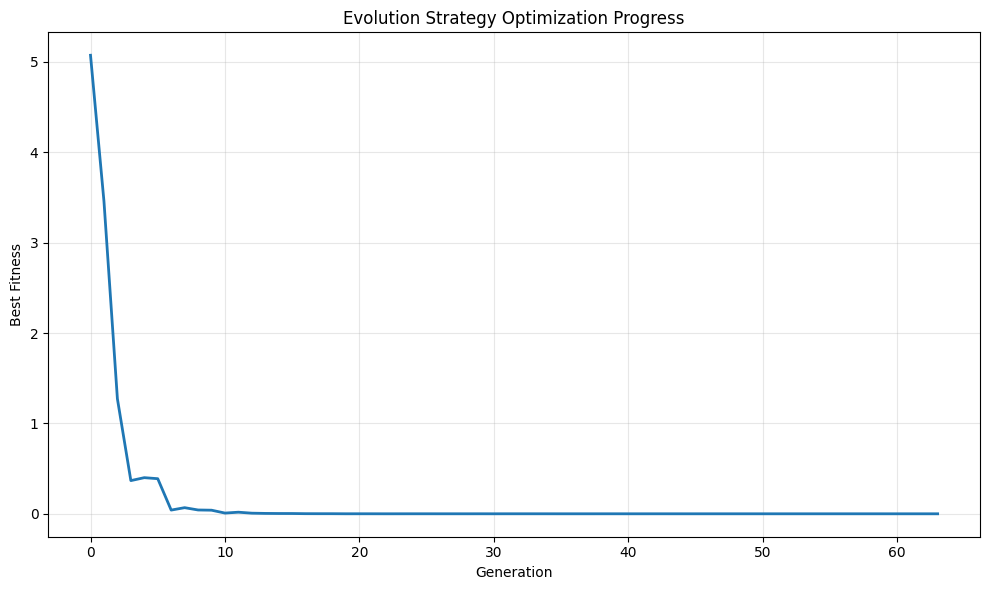

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(metrics["best_fitness"], linewidth=2)

plt.xlabel("Generation")
plt.ylabel("Best Fitness")

plt.title("Evolution Strategy Optimization Progress")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()